In [30]:
# follow this:
# https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/lorenz.inverse.html

In [31]:
import deepxde as dde
import numpy as np
from deepxde.backend import pytorch
import torch

In [32]:
alpha_real = 0.2
beta_real = 0.05
gamma_real = 0.01

total  [2.04643018e+05 1.47928048e+03 3.99489808e+06 7.98979617e+05]
total  5000000.000000002


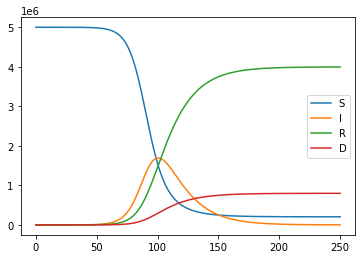

In [33]:
import ODE_SIR
solver = ODE_SIR.ODESolver()
t, wsol, N = solver.solve_SIRD(alpha_real, beta_real, gamma_real)
solver.plot_SIRD(t, wsol)

In [34]:
S_sol, I_sol, R_sol, D_sol = wsol[:,0], wsol[:,1], wsol[:,2], wsol[:,3]
init_num_people = np.sum(wsol[0,:])
S_sol, I_sol, R_sol, D_sol = S_sol/init_num_people, I_sol/init_num_people, R_sol/init_num_people, D_sol/init_num_people

In [35]:
timedomain = dde.geometry.TimeDomain(0, max(t))

In [36]:
alpha = dde.Variable(0.1)
beta = dde.Variable(0.1)
gamma = dde.Variable(0.1)

In [37]:
def pde(t, y):
    S, I = y[:, 0:1], y[:, 1:2]
    
    dS_t = dde.grad.jacobian(y, t, i=0)
    dI_t = dde.grad.jacobian(y, t, i=1)
    dR_t = dde.grad.jacobian(y, t, i=2)
    dD_t = dde.grad.jacobian(y, t, i=3)
    
    return [dS_t + alpha*S*I, 
           dI_t - alpha*S*I + beta*I + gamma*I,
           dR_t - beta*I,
           dD_t - gamma*I]

In [38]:
def boundary(_, on_initial):
    return on_initial

# Initial conditions
ic_S = dde.icbc.IC(timedomain, lambda X: torch.tensor(S_sol[0]).reshape(1,1), boundary, component=0)
ic_I = dde.icbc.IC(timedomain, lambda X: torch.tensor(I_sol[0]).reshape(1,1), boundary, component=1)
ic_R = dde.icbc.IC(timedomain, lambda X: torch.tensor(R_sol[0]).reshape(1,1), boundary, component=2)
ic_D = dde.icbc.IC(timedomain, lambda X: torch.tensor(D_sol[0]).reshape(1,1), boundary, component=3)

In [39]:
# Test points
observe_S = dde.icbc.PointSetBC(t.reshape(len(t), 1), S_sol.reshape(len(S_sol), 1), component=0)
observe_I = dde.icbc.PointSetBC(t.reshape(len(t), 1), I_sol.reshape(len(I_sol), 1), component=1)
observe_R = dde.icbc.PointSetBC(t.reshape(len(t), 1), R_sol.reshape(len(R_sol), 1), component=2)
observe_D = dde.icbc.PointSetBC(t.reshape(len(t), 1), D_sol.reshape(len(D_sol), 1), component=3)

In [40]:
data = dde.data.PDE(
    timedomain,
    pde,
    [ic_S, ic_I, ic_R, ic_D, 
     observe_S, observe_I,
     observe_R,observe_D
     ],
    num_domain=50,
    num_boundary=10,
    anchors=t.reshape(len(t), 1),
)

In [41]:
layer_size = [1] + [32] * 3 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [42]:
model = dde.Model(data, net)
variables = [alpha, beta, gamma]
model.compile("adam", lr=0.001, #metrics=["l2 relative error"], 
              external_trainable_variables=variables)

Compiling model...
'compile' took 0.000275 s



In [43]:
variable = dde.callbacks.VariableValue(variables, period=100)
losshistory, train_state = model.train(iterations=7500, callbacks=[variable])

Training model...

0         [1.65e-02, 3.30e-04, 4.21e-03, 1.90e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 2.40e+00, 1.16e-01, 1.82e-01, 9.20e-01]    [1.65e-02, 3.30e-04, 4.21e-03, 1.90e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 2.40e+00, 1.16e-01, 1.82e-01, 9.20e-01]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
100 [9.26e-02, 6.88e-02, 6.53e-02]
200 [9.61e-02, 5.21e-02, 4.05e-02]
300 [9.85e-02, 4.35e-02, 2.35e-02]
400 [1.01e-01, 4.38e-02, 1.42e-02]
500 [1.02e-01, 4.76e-02, 9.61e-03]
600 [1.04e-01, 5.05e-02, 6.95e-03]
700 [1.06e-01, 5.21e-02, 5.68e-03]
800 [1.08e-01, 5.27e-02, 5.29e-03]
900 [1.10e-01, 5.28e-02, 5.26e-03]
1000      [2.50e-05, 7.80e-06, 6.15e-06, 1.27e-06, 1.12e-07, 3.15e-09, 5.23e-10, 1.38e-09, 8.04e-03, 4.24e-03, 3.16e-03, 1.44e-04]    [2.50e-05, 7.80e-06, 6.15e-06, 1.27e-06, 1.12e-07, 3.15e-09, 5.23e-10, 1.38e-09, 8.04e-03, 4.24e-03, 3.16e-03, 1.44e-04]    []  
1000 [1.12e-01, 5.26e-02, 5.33e-03]
1100 [1.15e-01, 5.23e-02, 5.40e-03]
1200 [1.17e-01, 5.19e-02, 5.52e-03]

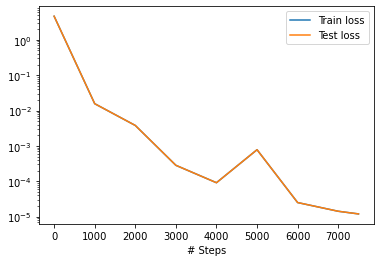

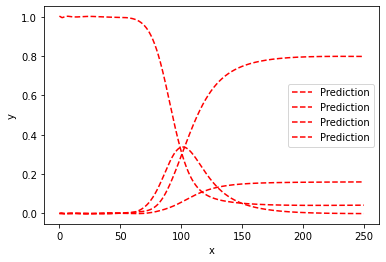

In [44]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)